<a href="https://colab.research.google.com/github/anthonymghms/ExploreAR/blob/main/SAMBoundedBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
import tensorflow as tf

# List physical devices
physical_devices = tf.config.list_physical_devices()
print("Physical devices:", physical_devices)
print(tf.__version__)
# Test GPU availability
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Default GPU Device: /device:GPU:0


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: d:\ExploreAR


## Install Segment Anything Model (SAM) and other dependencies

In [4]:
%pip install -q git+https://github.com/facebookresearch/segment-anything.git

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

Note: you may need to restart the kernel to use updated packages.


### Download SAM weights

In [2]:
%mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights


The syntax of the command is incorrect.


In [4]:
import os


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
data_dir = os.path.join(os.path.expanduser('.'), 'data')
os.makedirs(data_dir, exist_ok=True)
print(f"Directory '{data_dir}' has been created.")

d:\ExploreAR\weights\sam_vit_h_4b8939.pth ; exist: True
Directory '.\data' has been created.


## Load Model

In [1]:
import torch
print(torch.cuda.is_available())
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

True


In [5]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [6]:
mask_predictor = SamPredictor(sam)

In [7]:
import os

IMAGE_NAME = "Baalbek.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [8]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [9]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [10]:
widget.bboxes

[{'x': 160, 'y': 15, 'width': 327, 'height': 286, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [11]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [12]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

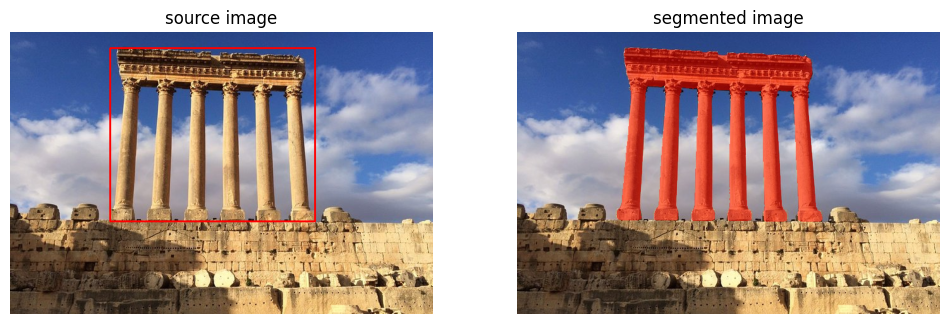

In [14]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

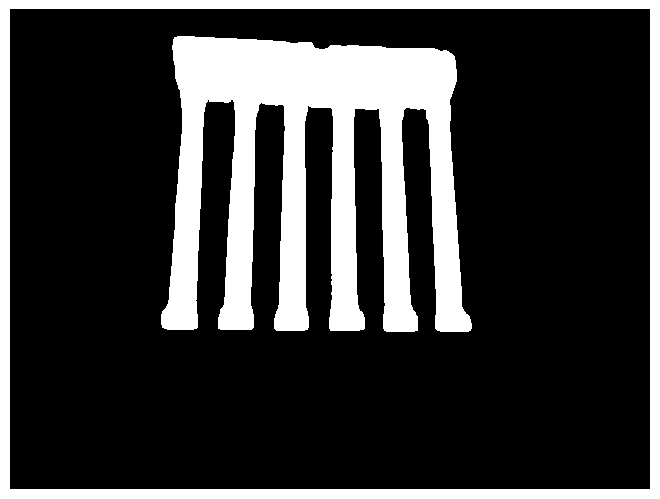

In [19]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(masks[2], interpolation='nearest', cmap='gray', aspect='auto')
plt.savefig('./data/Mask.png')

### Interaction with segmentation results

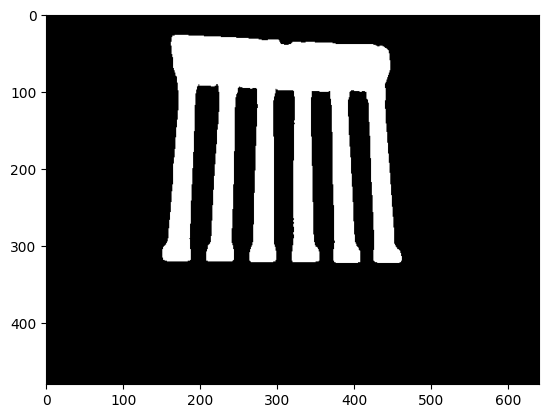

In [37]:
import numpy as np
import cv2 as cv
filename = './data/Mask.png'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# find Harris corners
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
dst = cv.dilate(dst,None)
ret, dst = cv.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
# find centroids
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
hull = cv2.convexHull(corners)
cleaned_hull = []

# Iterate through the convex hull points
for point in hull:
    # Convert the point to a list and then back to a numpy array with a float data type
    cleaned_point = np.array(point[0].tolist(), dtype=np.float32)
    # Append the cleaned point to the cleaned_hull list
    cleaned_hull.append(cleaned_point)

cleaned_hull = np.array(cleaned_hull)

plt.imshow(img)
plt.show()


In [28]:
import math

"""
Minimal Enclosing Parallelogram

area, v1, v2, v3, v4 = mep(convex_polygon)

convex_polygon - array of points. Each point is a array [x, y] (1d array of 2 elements)
points should be presented in clockwise order.

the algorithm used is described in the following paper:
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.53.9659&rep=rep1&type=pdf
"""

def distance(p1, p2, p):
    return abs(((p2[1]-p1[1])*p[0] - (p2[0]-p1[0])*p[1] + p2[0]*p1[1] - p2[1]*p1[0]) /
        math.sqrt((p2[1]-p1[1])**2 + (p2[0]-p1[0])**2))

def antipodal_pairs(convex_polygon):
    l = []  # noqa: E741
    n = len(convex_polygon)
    p1, p2 = convex_polygon[0], convex_polygon[1]

    t, d_max = None, 0
    for p in range(1, n):
        d = distance(p1, p2, convex_polygon[p])
        if d > d_max:
            t, d_max = p, d
    l.append(t)

    for p in range(1, n):
        p1, p2 = convex_polygon[p % n], convex_polygon[(p+1) % n]
        _p, _pp = convex_polygon[t % n], convex_polygon[(t+1) % n]
        while distance(p1, p2, _pp) > distance(p1, p2, _p):
            t = (t + 1) % n
            _p, _pp = convex_polygon[t % n], convex_polygon[(t+1) % n]
        l.append(t)

    return l


# returns score, area, points from top-left, clockwise , favouring low area
def mep(convex_polygon):
    def compute_parallelogram(convex_polygon, l, z1, z2):  # noqa: E741
        def parallel_vector(a, b, c):
            v0 = [c[0]-a[0], c[1]-a[1]]
            v1 = [b[0]-c[0], b[1]-c[1]]
            return [c[0]-v0[0]-v1[0], c[1]-v0[1]-v1[1]]

        # finds intersection between lines, given 2 points on each line.
        # (x1, y1), (x2, y2) on 1st line, (x3, y3), (x4, y4) on 2nd line.
        def line_intersection(x1, y1, x2, y2, x3, y3, x4, y4):
            px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
            py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
            return px, py


        # from each antipodal point, draw a parallel vector,
        # so ap1->ap2 is parallel to p1->p2
        #    aq1->aq2 is parallel to q1->q2
        p1, p2 = convex_polygon[z1 % n], convex_polygon[(z1+1) % n]
        q1, q2 = convex_polygon[z2 % n], convex_polygon[(z2+1) % n]
        ap1, aq1 = convex_polygon[l[z1 % n]], convex_polygon[l[z2 % n]]
        ap2, aq2 = parallel_vector(p1, p2, ap1), parallel_vector(q1, q2, aq1)

        a = line_intersection(p1[0], p1[1], p2[0], p2[1], q1[0], q1[1], q2[0], q2[1])
        b = line_intersection(p1[0], p1[1], p2[0], p2[1], aq1[0], aq1[1], aq2[0], aq2[1])
        d = line_intersection(ap1[0], ap1[1], ap2[0], ap2[1], q1[0], q1[1], q2[0], q2[1])
        c = line_intersection(ap1[0], ap1[1], ap2[0], ap2[1], aq1[0], aq1[1], aq2[0], aq2[1])

        s = distance(a, b, c) * math.sqrt((b[0]-a[0])**2 + (b[1]-a[1])**2)
        return s, a, b, c, d


    z1, z2 = 0, 0
    n = len(convex_polygon)

    # for each edge, find antipodal vertice for it (step 1 in paper).
    l = antipodal_pairs(convex_polygon)  # noqa: E741

    so, ao, bo, co, do, z1o, z2o = 100000000000, None, None, None, None, None, None

    # step 2 in paper.
    for z1 in range(0, n):
        if z1 >= z2:
            z2 = z1 + 1
        p1, p2 = convex_polygon[z1 % n], convex_polygon[(z1+1) % n]
        a, b, c = convex_polygon[z2 % n], convex_polygon[(z2+1) % n], convex_polygon[l[z2 % n]]
        if distance(p1, p2, a) >= distance(p1, p2, b):
            continue

        while distance(p1, p2, c) > distance(p1, p2, b):
            z2 += 1
            a, b, c = convex_polygon[z2 % n], convex_polygon[(z2+1) % n], convex_polygon[l[z2 % n]]

        st, at, bt, ct, dt = compute_parallelogram(convex_polygon, l, z1, z2)

        if st < so:
            so, ao, bo, co, do, z1o, z2o = st, at, bt, ct, dt, z1, z2

    return so, ao, bo, co, do, z1o, z2o

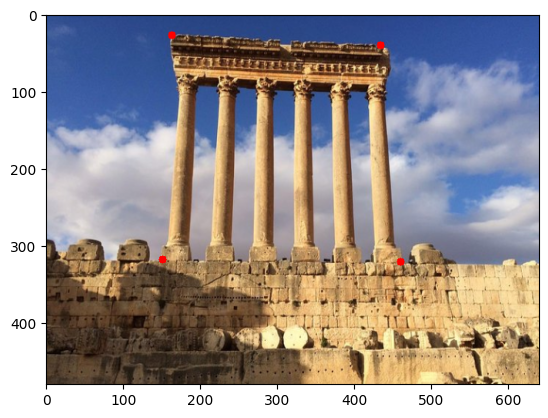

In [36]:
area, v1, v2, v3, v4, z1o, z2o = mep(cleaned_hull)

points = []
points.append(v1)
points.append(v2)
points.append(v3)
points.append(v4)
mep_points = np.array(points)
def find_closest_hull_point(mep_point, cleaned_hull):
    # Calculate the distance from the mep point to each point in the cleaned hull
    distances = np.linalg.norm(cleaned_hull - mep_point, axis=1)
    # Find the index of the closest point
    closest_point_index = np.argmin(distances)
    # Return the closest point
    return cleaned_hull[closest_point_index]

closest_points = []

for point in mep_points:
  closest_point = find_closest_hull_point(point, cleaned_hull)
  closest_points.append(closest_point)

closest_points = np.array(closest_points)
newfilename = './data/Baalbek.jpg'
image = cv.resize(cv.imread(newfilename),(640,480))

for point in closest_points:
  x1,y1 = point.astype(int)
  cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)  # Red color

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Example coordinates of the 4 corners of the polygon
x_points = closest_points[:, 0] #[438.40125, 222.38367, 238.83333, 452.04208  ]
y_points = closest_points[:, 1] #[65.85885, 148.62517, 387.66666, 361.9711]

# Since the plotting code expects the first point to be repeated at the end to close the polygon:
x_points = np.append(x_points, x_points[0])
y_points = np.append(y_points, y_points[0])

# Now you can use the plotting code as before, with these x_points and y_points

plt.figure(figsize=(5,5))
plt.plot(x_points, y_points, marker='o') # Plot the points and connect them
plt.fill(x_points, y_points, alpha=0.4)  # Optionally fill the polygon, adjust alpha for transparency

# Set plot limits to make sure all points are easily visible
plt.xlim(min(x_points) - 1, max(x_points) + 1)
plt.ylim(min(y_points) - 1, max(y_points) + 1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polygon with 4 Corners')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming closest_points is a numpy array of your polygon's vertices
x_points = closest_points[:, 0]
y_points = closest_points[:, 1]

# Flip the polygon upside down
y_max = max(y_points)
y_points_upside_down = y_max - y_points + min(y_points)  # Adjusting to maintain the plot within view

# Flip the polygon left to right
x_max = max(x_points)
x_points_left_right = x_max - x_points + min(x_points)  # Adjusting to maintain the plot within view


# Plot upside down polygon
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 2)
plt.plot(np.append(x_points, x_points[0]), np.append(y_points_upside_down, y_points_upside_down[0]), marker='o')
plt.fill(x_points, y_points_upside_down, alpha=0.4)
plt.title('Upside Down Polygon')

plt.tight_layout()
plt.show()




In [ ]:
import numpy as np

# Coordinates of the upside down polygon
x_points_upside_down = x_points  # The x coordinates stay the same when flipped upside down
y_points_upside_down = y_max - y_points + min(y_points)  # Calculate the y coordinates for the flipped polygon

# Ensure the points form a closed loop by repeating the first point at the end
x_points_closed = np.append(x_points_upside_down, x_points_upside_down[0])
y_points_closed = np.append(y_points_upside_down, y_points_upside_down[0])

# Calculate the distances between consecutive points
distances = np.sqrt(np.diff(x_points_closed)**2 + np.diff(y_points_closed)**2)

for i, d in enumerate(distances, 1):
    print(f"Distance between point {i} and point {(i % 4) + 1}: {d:.2f}")

# If you want to sum the distances to get the perimeter of the polygon
perimeter = np.sum(distances)
print(f"The perimeter of the upside down polygon is: {perimeter:.2f}")